In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

In [2]:
import textdistance
import string
from sklearn.cluster import DBSCAN

In [3]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
print("Read {} records.".format(len(df_canvass)))

Read 50462 records.


In [4]:
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
print("Read {} records.".format(len(df_complaint)))

Read 17088 records.


In [5]:
df_all = pd.concat([df_canvass, df_complaint])
df_all.head()

,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,1981667,1725 W 47TH ST,BELLAS FUENTEZ,CHICAGO,BELLAS FUENTEZ,Restaurant,2017-01-19T00:00:00.000,Canvass,41.808460,1356217,...,0,0,0,0,0,0,0,0,0,0
1,1453500,65 W JACKSON BLVD,CARVERY,CHICAGO,CARVERY,Restaurant,2014-08-26T00:00:00.000,Canvass,41.878046,43330,...,0,0,0,0,0,0,0,0,0,0
2,1102252,11601 W TOUHY AVE,THE GREAT AMERICAN BAGEL/T3 K2,CHICAGO,THE GREAT AMERICAN BAGEL,Restaurant,2012-05-07T00:00:00.000,Canvass,42.008536,1879167,...,0,0,0,0,0,0,0,0,0,0
3,68091,2804 N CLARK ST,Wells Street Popcorn,CHICAGO,Wells Street Popcorn,Restaurant,2010-02-01T00:00:00.000,Canvass,41.932921,1954774,...,0,0,0,0,0,0,0,0,0,0
4,1482983,1847 W ROSCOE ST,FOUR MOON TAVERN,CHICAGO,FOUR MOON TAVERN,Restaurant,2015-09-14T00:00:00.000,Canvass,41.943141,51644,...,0,0,0,0,0,0,0,0,0,0


In [6]:
key_col = "license_id"
name_col = "aka_name"
lid_aka = df_all.groupby(key_col)[name_col].unique()
lid_aka.head()
name_df = pd.DataFrame({key_col: lid_aka.index, name_col: lid_aka.values})
name_df["N"] = name_df[name_col].apply(lambda a: len(a))

In [7]:
name_df.sort_values(by="N", ascending=False)[20:30]

,license_id,aka_name,N
9077,2220904,"[STREETERVILLE PIZZERIA & TAP, FLOUR & STONE, ...",3
5324,1893935,"[AQUA BAR & GRILL, TWISTED TAPAS, nan]",3
6851,2027309,"[CENTRO, BAR UMBRIAGO, ROSEBUD EATT]",3
96,1806,"[AMBASSADOR PUBLIC HOUSE, BOUZOUKI LOUNGE, AVIVA]",3
5714,1933945,"[NEW REBOZO CHICAGO, CANTINA #46, CANTINA 46]",3
8003,2120365,"[UR INN, Tortuga's Cantina]",2
6774,2021306,"[Chizakaya, ENTENTE]",2
10315,2340467,"[MANZO'S BURGER, FIVE STAR BURGER]",2
4517,1767227,"[I-CAFE, I - CAFE PIDE VE LAHMACUN]",2
11031,2391299,"[ANALOGUE, DAISIES]",2


In [8]:
zoot_all = df_all.groupby(key_col)["inspection_id"].count().sort_values(ascending=False)
dict_all = {name_col: [lid_aka[z] for z in zoot_all.index], "count": zoot_all.values}
zdf_all = pd.DataFrame(dict_all)
zdf_all[20:30]

,aka_name,count
20,[CHURCH'S CHICKEN # 982],22
21,[MAGGIE GYROS & CHICKEN],22
22,[MCDONALD'S],22
23,[DUKS RED HOTS],22
24,[HONG KONG BUFFET],21
25,[MC DONALDS],21
26,[SEE THRU CHINESE RESTAURANT],21
27,[NICKY'S CHINESE FOOD],21
28,[MC DONALDS],21
29,[CHIPOTLE MEXICAN GRILL],21


In [9]:
textdistance.jaro_winkler.similarity("McDONALDS".casefold(), "MCDONALDS RESTAURANT".casefold())

0.89

In [10]:
name_count = df_all.groupby("aka_name")["inspection_id"].count()
names = list(name_count.sort_values(ascending=False).head(500).index)
# names = list(name_count.index)

In [11]:
BANNED = list(string.punctuation) + [
    "restaurant",
    "star ",
    "house",
    "kitchen",
    "original",
    "the",
    "new"
] + [" "]
BANNED = [ban.casefold() for ban in BANNED]
CUT_CHARS = ["#", "("]

def clean_name(name):
    cleaned = name.casefold()
    for cut in CUT_CHARS:
        idx = cleaned.find(cut)
        if idx > 0:
            cleaned = cleaned[:idx]
    for ban in BANNED:
        cleaned = cleaned.replace(ban, "")
    return cleaned

In [12]:
n_clean = 5
print(names[0:n_clean])
print([clean_name(n) for n in names[0:n_clean]])

['SUBWAY', 'DUNKIN DONUTS', "MCDONALD'S", 'CHIPOTLE MEXICAN GRILL', 'MCDONALDS']
['subway', 'dunkindonuts', 'mcdonalds', 'chipotlemexicangrill', 'mcdonalds']


In [13]:
mat = np.zeros((len(names), len(names)))
pairs = []
for i, a in enumerate(names):
    for j, b in enumerate(names):
        a_clean = clean_name(a)
        b_clean = clean_name(b)
        sim = textdistance.jaro_winkler.similarity(a_clean, b_clean)
        dist = 1 - sim
        mat[i][j] = dist
        if j > i:
            pairs.append((i, j, a, b, a_clean, b_clean, dist))
print(len(pairs), ((len(names)**2) - len(names)) // 2)

124750 124750


In [14]:
pd.DataFrame(mat, columns=names, index=names).head()

,SUBWAY,DUNKIN DONUTS,MCDONALD'S,CHIPOTLE MEXICAN GRILL,MCDONALDS,DUNKIN DONUTS/BASKIN ROBBINS,POTBELLY SANDWICH WORKS,BURGER KING,CORNER BAKERY CAFE,STARBUCKS COFFEE,...,FRANK'S CHICAGO SHRIMP HOUSE,HELLAS GYROS,XSPORT FITNESS,FREDDIES,TAQUERIA LOS COMALES #1,SOUTH CHINA KITCHEN INC.,BERGHOFF CAFE (T1 C26),LAZO'S TACOS,PAPI'S TACOS,LU-LU'S INC
SUBWAY,0.000000,0.583333,0.574074,0.594444,0.574074,0.474444,0.442857,0.655556,0.437500,0.438889,...,0.687135,0.494949,0.585470,1.000000,0.685185,0.423077,0.500000,0.655556,0.655556,0.569444
DUNKIN DONUTS,0.583333,0.000000,0.442593,0.613889,0.442593,0.104000,0.571429,0.422222,0.687500,0.550000,...,0.540058,0.550505,0.532906,0.472222,0.481481,0.452991,0.611111,0.483333,0.505556,0.569444
MCDONALD'S,0.574074,0.442593,0.000000,0.564815,0.000000,0.503333,0.488095,0.596296,0.435185,0.600000,...,0.573343,0.575758,0.478632,0.430556,0.569444,0.499288,0.537037,0.566667,0.525926,0.587963
CHIPOTLE MEXICAN GRILL,0.594444,0.613889,0.564815,0.000000,0.564815,0.510000,0.441270,0.550000,0.499405,0.572222,...,0.441228,0.456926,0.579487,0.602778,0.481481,0.452564,0.511111,0.516667,0.505556,0.558333
MCDONALDS,0.574074,0.442593,0.000000,0.564815,0.000000,0.503333,0.488095,0.596296,0.435185,0.600000,...,0.573343,0.575758,0.478632,0.430556,0.569444,0.499288,0.537037,0.566667,0.525926,0.587963


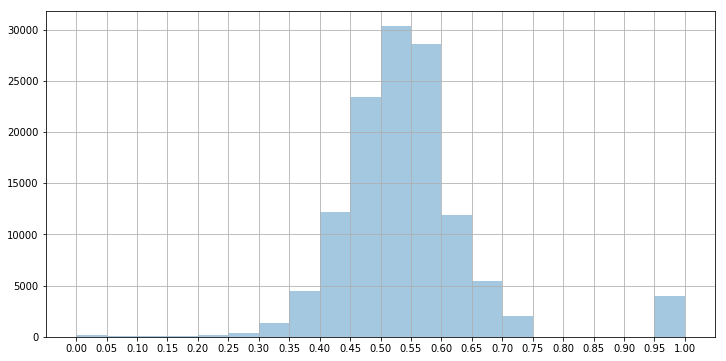

In [15]:
sns.distplot([p[6] for p in pairs], kde=False, bins=np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 1.05, 0.05))
plt.grid()
plt.gcf().set_size_inches(12, 6)
plt.show()

In [16]:
pair_df = pd.DataFrame(pairs, columns=["i", "j", "a", "b", "a_clean", "b_clean", "dist"])
pair_df.sort_values(by="dist", ascending=False).query("dist >= 0.15 and dist <= 0.18")

,i,j,a,b,a_clean,b_clean,dist
61049,142,345,CHICAGO'S PIZZA,Chicago DQ Grill and Chill,chicagospizza,chicagodqgrillandchill,0.179720
40134,88,139,ROTI,ROSATI'S PIZZA,roti,rosatispizza,0.177778
83843,213,348,CAFE HOANG,CAFE ZOOTS (T1 C18 FOODCOURT),cafehoang,cafezoots,0.177778
40732,89,327,CHINESE KITCHEN,CHILI'S (T1-B14),chinese,chilis,0.177778
98266,269,351,PAPA ROMEO'S PIZZA,TOPPERS PIZZA,paparomeospizza,topperspizza,0.177273
55497,127,253,JIMMY JOHNS SANDWICH SHOPS,JIMMY G'S,jimmyjohnssandwichshops,jimmygs,0.176398
47772,107,158,PIZZA CAPRI,PIZZERIA DUE,pizzacapri,pizzeriadue,0.175584
30188,64,333,CHIPOTLE,CHILI'S TOO (T3-H2),chipotle,chilistoo,0.175000
30232,64,377,CHIPOTLE,CHILI'S TOO (T3 G9),chipotle,chilistoo,0.175000
30137,64,282,CHIPOTLE,CHILI'S TOO (T2 F4),chipotle,chilistoo,0.175000


In [17]:
dbscan = DBSCAN(eps=0.15, metric="precomputed", min_samples=1)
clusters = dbscan.fit_predict(mat)
len(np.unique(clusters))

345

In [18]:
cluster_dict = {}
for name, cluster in zip(names, clusters):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(name)

In [19]:
cdf = pd.DataFrame(cluster_dict.items(), columns=["Cluster", "Restaurants"])
cdf["Names"] = cdf["Restaurants"].apply(lambda a: len(a))
cdf["Inspections"] = cdf["Restaurants"].apply(lambda a: np.sum([name_count[n] for n in a]))
cdf.sort_values(by="Inspections", ascending=False).head(30)

,Cluster,Restaurants,Names,Inspections
0,0,"[SUBWAY, Subway, SUBWAY SANDWICHES, SUBWAY SAN...",9,2544
1,1,"[DUNKIN DONUTS, DUNKIN DONUTS/BASKIN ROBBINS, ...",9,1376
2,2,"[MCDONALD'S, MCDONALDS, MC DONALD'S, MC DONALD...",11,1146
4,4,"[POTBELLY SANDWICH WORKS, POTBELLY SANDWICH WO...",4,398
21,21,"[POPEYES, POPEYE'S, POPEYES CHICKEN, POPEYE'S ...",10,390
3,3,"[CHIPOTLE MEXICAN GRILL, Chipotle Mexican Gril...",3,359
9,9,"[JIMMY JOHN'S, JIMMY JOHNS, Jimmy Johns, JIMMY...",5,315
7,7,"[STARBUCKS COFFEE, STARBUCKS]",2,292
61,61,"[CHINESE KITCHEN, NEW CHINA BUFFET, CHINA CHEF...",9,198
5,5,[BURGER KING],1,190


In [20]:
for r in cdf["Restaurants"].values[:10]:
    print(r)
    print()

['SUBWAY', 'Subway', 'SUBWAY SANDWICHES', 'SUBWAY SANDWICH', 'SUBWAY SANDWICH & SALAD', 'SUBWAY (T3 ROTUNDA)', 'SUBWAY #3333', 'SUBWAY RESTAURANT', 'SUBWAY SANDWICHES & SALADS']

['DUNKIN DONUTS', 'DUNKIN DONUTS/BASKIN ROBBINS', 'DUNKIN DONUTS BASKIN ROBBINS', 'DUNKIN DONUTS / BASKIN ROBBINS', 'DUNKIN DONUTS / BASKIN ROBINS', 'DUNKIN DONUTS/ BASKIN ROBBINS', 'Dunkin Donuts', 'DUNKIN DONUTS / BASKIN & ROBBINS', 'DUNKIN DONUT']

["MCDONALD'S", 'MCDONALDS', "MC DONALD'S", 'MC DONALDS', "McDONALD'S", "MCDONALD'S RESTAURANT", 'MCDONALDS RESTAURANT', 'McDONALDS', 'McDonalds', "McDonald's", "McDonald's Restaurant"]

['CHIPOTLE MEXICAN GRILL', 'Chipotle Mexican Grill', 'CHIPOTLE']

['POTBELLY SANDWICH WORKS', 'POTBELLY SANDWICH WORKS LLC', 'POTBELLY SANDWICH SHOP', 'POTBELLY']

['BURGER KING']

['CORNER BAKERY CAFE']

['STARBUCKS COFFEE', 'STARBUCKS']

["WENDY'S", "Wendy's"]

["JIMMY JOHN'S", 'JIMMY JOHNS', 'Jimmy Johns', 'JIMMY JOHNS SANDWICH SHOPS', "JIMMY G'S"]



In [28]:
not_clustered = list(filter(lambda n: n not in names, name_count.index))
sorted([(n, name_count[n]) for n in not_clustered], key=lambda p: p[1], reverse=True)

[('ADOBO GRILL', 14),
 ("AL'S ITALIAN BEEF INC", 14),
 ('ALLIS & CHICKEN SHOP', 14),
 ('BANDERA', 14),
 ('BEEF AND BRANDY RESTAURANT', 14),
 ("BENNY'S PIZZA", 14),
 ('BRASA ROJA RESTAURANT', 14),
 ('BREAD BASKET', 14),
 ('BURGER KING #7623', 14),
 ('BUTTERFLY SUSHI BAR', 14),
 ('CAFE DESCARTES', 14),
 ("ED'S POTSTICKER HOUSE", 14),
 ('EJ SUSHI', 14),
 ('EL SOLAZO', 14),
 ('FIRST SLICE PIE CAFE', 14),
 ("FLACO'S TACOS", 14),
 ("GASLIGHT CLUB (HILTON O'HARE LOBBY)", 14),
 ('HAROLDS CHICKEN #2', 14),
 ('HOLLYWOOD GRILL', 14),
 ('IRAZU INC', 14),
 ("JEFF'S RED HOTS", 14),
 ('JIMMY JOHNS GOURMET SANDWICHES', 14),
 ('JJ FISH & CHICKEN', 14),
 ('JOY YEE NOODLE', 14),
 ('LAO SZE CHUAN', 14),
 ('LAS TABLAS', 14),
 ("MCDONALD'S CORPORATION", 14),
 ('MERCHANT CAFE/CITYSCAPE BAR', 14),
 ("MORTON'S STEAKHOUSE", 14),
 ('ORIENTAL CHEF', 14),
 ('ORIGINAL HALSTED MAXWELL STREET POLISH', 14),
 ('PANDA EXPRESS #1345', 14),
 ('PANDA EXPRESS #1422', 14),
 ('PIZZA NOVA INC', 14),
 ('QDOBA', 14),
 ("RAYMOND'